<a href="https://colab.research.google.com/github/poliduckie/MPC/blob/main/One_LaneDetection_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS



In [3]:
!pip install moviepy
!pip install ipython
!pip install opencv-python
!pip install glob2
!git clone https://github.com/uppala75/CarND-Advanced-Lane-Lines.git
!pip install pickle
!pip install tracker
%cd CarND-Advanced-Lane-Lines
%mkdir duckie_img

from google.colab import drive
drive.mount('/content/drive')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'CarND-Advanced-Lane-Lines'...
remote: Enumerating objects: 143, done.
remote: Total 143 (delta 0), reused 0 (delta 0), pack-reused 143
Receiving objects: 100% (143/143), 18.87 MiB | 30.72 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
Looking in indexes: https://pypi.org/simple, https://u

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import cv2 
import glob
import pickle
from tracker import tracker
import os


In [5]:
# Read and make a list of test images
images = glob.glob('/content/drive/My Drive/*.png')
gidx = 0


# SUPPORT FUNCTIONS

In [8]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.

def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > vthresh[0]) & (v_channel <= vthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary) == 1] = 1

    # Return the combined s_channel & v_channel binary image
    return output

def s_channel_threshold(image, sthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]  # use S channel

    # create a copy and apply the threshold
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    return binary_output

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height), max(0,int(center-width)):min(int(center+width),img_ref.shape[1])] = 1
    return output

# BIRD EYE

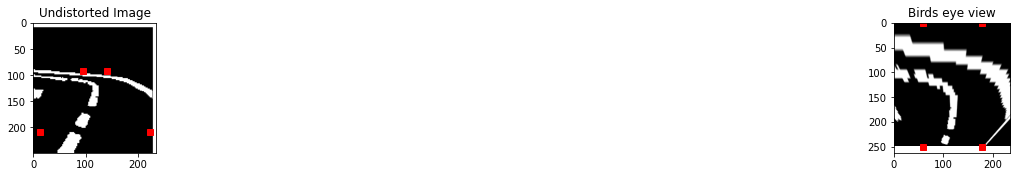

In [9]:

#read in image
img = cv2.imread(images[0])
#undistort the image
#img = cv2.undistort(img,mtx,dist,None,mtx)
  #img = cv2.undistort(img,mtx,dist,None,mtx)
y=0
x=50
h=250
w=300
img = img[y:y+h, x:x+w]
preprocessImage=img[:,:,0]

img_size = (img.shape[1],img.shape[0])

bot_width = .9 # percentage of bottom trapezoidal height
mid_width = .2 # percentage of mid trapezoidal height
height_pct = .37 # percentage of trapezoidal height
bottom_trim= .835 # percentage from top to bottom avoiding the hood of the car

src = np.float32([[img.shape[1]*(0.5-mid_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
offset = img_size[0]*0.25
dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])

#perform the warp perspective transform
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst,src)
warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)


#Visualize the results before/after warping for a birds-eye view along with the source & destination co-ordinate locations
plt.figure(figsize = (30,20))
grid = gridspec.GridSpec(8,2)
# set the spacing between axes.
grid.update(wspace=0.05, hspace=0.05)  

plt.subplot(grid[gidx])
plt.imshow(img, cmap="gray")
for i in range(4):
    plt.plot(src[i][0],src[i][1],'rs')
plt.title('Undistorted Image')

plt.subplot(grid[gidx+1])
plt.imshow(warped, cmap="gray")
for i in range(4):
    plt.plot(dst[i][0],dst[i][1],'rs')
plt.title('Birds eye view')

plt.show()





#SLIDING WINDOW

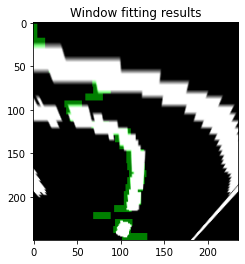

In [10]:

window_width = 10
window_height = 8

#set up the overall class to do the lane line tracking
curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin = 25, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)

window_centroids = curve_centers.find_window_centroids(warped)

# Points used to draw all the left and right windows
l_points = np.zeros_like(warped)
r_points = np.zeros_like(warped)
    
# points used to find the right & left lanes
rightx = []
leftx = []

# Go through each level and draw the windows 
for level in range(0,len(window_centroids)):
    # Window_mask is a function to draw window areas
    # Add center value found in frame to the list of lane points per left, right
    leftx.append(window_centroids[level][0])
    rightx.append(window_centroids[level][1])

    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
    # Add graphic points from window mask here to total pixels found 
    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

# Draw the results
template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
zero_channel = np.zeros_like(template) # create a zero color channel
template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results




#Visualize the results of the window fitting to lane lines
plt.imshow(result, cmap='gray')
plt.title('Window fitting results')
plt.show()



# POLYNOMIAL FITTING

Text(0.5, 1.0, 'Lane lines overlapped on original image')

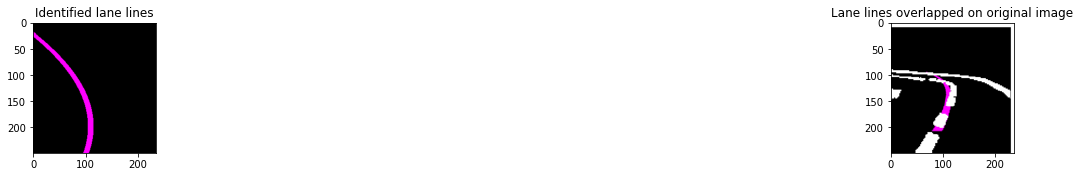

In [11]:
#fit the lane boundaries to the left, right center positions found
yvals = range(0,warped.shape[0])

res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)

left_fit = np.polyfit(res_yvals, leftx, 2)
left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
left_fitx = np.array(left_fitx,np.int32)

right_fit = np.polyfit(res_yvals, rightx, 2)
right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
right_fitx = np.array(right_fitx,np.int32)

left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

road = np.zeros_like(img)
road_bkg = np.zeros_like(img)
cv2.fillPoly(road,[left_lane],color=[255,0,255])
#cv2.fillPoly(road,[right_lane],color=[0,0,255])#temp removed
cv2.fillPoly(road_bkg,[left_lane],color=[255,255,255])
cv2.fillPoly(road_bkg,[right_lane],color=[255,255,255])

road_warped = cv2.warpPerspective(road,Minv,img_size,flags=cv2.INTER_LINEAR)
road_warped_bkg= cv2.warpPerspective(road_bkg,Minv,img_size,flags=cv2.INTER_LINEAR)

base = cv2.addWeighted(img,1.0,road_warped, -1.0, 0.0)
result = cv2.addWeighted(base,1.0,road_warped, 1.0, 0.0)

#Visualize the results of identified lane lines and overlapping them on to the original undistorted image
plt.figure(figsize = (30,20))
grid = gridspec.GridSpec(8,2)
# set the spacing between axes.
grid.update(wspace=0.05, hspace=0.05)  

#img_plt = plt.subplot(grid[0])
plt.subplot(grid[gidx])
plt.imshow(road, cmap="gray")
plt.title('Identified lane lines')

#img_plt = plt.subplot(grid[1])
plt.subplot(grid[gidx+1])
plt.imshow(result, cmap="gray")
plt.title('Lane lines overlapped on original image')
